In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random 
import numpy as np
import math
%matplotlib inline

In [41]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [42]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)
inx_to_str

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [43]:
# build the dataset
random.shuffle(words)
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1


X, Y = torch.tensor(X), torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0, 20],
        [ 0, 20,  9],
        ...,
        [ 1, 25, 12],
        [25, 12,  5],
        [12,  5, 14]])

In [44]:
# data set splits
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

Why *0.01, etc.? Weights are deviating from 0 too much (i.e they're very wrong) at the initialization and it unnecessarily increases the loss at the beginning of the training. When they are too diverse tanh produces values very close to -1 or 1 which is bad for the gradient flow (see micrograd tanh implementation; gradient doesn't flow because it's in the flattened region). Init weight should be very close to 0 but not 0

In [45]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * (5/3)*(block_size*n_embd)**0.5 #Kaiming init
#b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
batch_norm_gain = torch.ones((1, n_hidden))  # shift
batch_norm_bias = torch.zeros((1, n_hidden)) # property
batch_mean_running = torch.zeros((1, n_hidden))
batch_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, batch_norm_gain, batch_norm_bias]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

12097

In [70]:
# train
inxs = []
losses = []
batch_size = 32
steps = 100000
for i in range(steps):
    # minibatch construct
    inx = torch.randint(0, training_set.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[training_set[inx]] # grab only those rows from the minibatch 
    emb_conc = emb.view(-1, block_size*n_embd)

    # linear layer
    h_preact = emb_conc @ W1 #+ b1 adding b1 is wasteful - see mu and std

    # BatchNorm Layer
    batch_mean_i = h_preact.mean(dim=0, keepdim=True)
    batch_std_i = h_preact.std(dim=0, keepdim=True)
    h_preact = batch_norm_gain * (h_preact - batch_mean_i) / batch_std_i + batch_norm_bias
    with torch.no_grad(): # may well be calculated after training, see below
        batch_mean_running = 0.999 * batch_mean_running + 0.001 * batch_mean_i
        batch_std_running = 0.999 * batch_std_running + 0.001 * batch_std_i
        
    # non-linearity
    h = torch.tanh(h_preact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_training_set[inx]) 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    l_r = 0.1 if i < 50000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -l_r * p.grad

    #stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    inxs.append(i)
loss.item() # best loss 2.14

      0/ 100000: 2.4717
   1000/ 100000: 2.1026
   2000/ 100000: 2.3364
   3000/ 100000: 2.4489
   4000/ 100000: 2.0868
   5000/ 100000: 2.5001
   6000/ 100000: 2.3688
   7000/ 100000: 2.5607
   8000/ 100000: 2.0939
   9000/ 100000: 2.4780
  10000/ 100000: 2.1404
  11000/ 100000: 2.1055
  12000/ 100000: 2.3056
  13000/ 100000: 2.2276
  14000/ 100000: 1.9995
  15000/ 100000: 2.6928
  16000/ 100000: 2.2209
  17000/ 100000: 2.0405
  18000/ 100000: 2.1769
  19000/ 100000: 2.1846
  20000/ 100000: 2.2120
  21000/ 100000: 2.0745
  22000/ 100000: 2.3049
  23000/ 100000: 2.5951
  24000/ 100000: 2.5303
  25000/ 100000: 2.6730
  26000/ 100000: 2.4126
  27000/ 100000: 2.1472
  28000/ 100000: 2.3460
  29000/ 100000: 2.1826
  30000/ 100000: 2.0227
  31000/ 100000: 2.8046
  32000/ 100000: 2.2194
  33000/ 100000: 2.1179
  34000/ 100000: 2.1639
  35000/ 100000: 2.0730
  36000/ 100000: 2.4407
  37000/ 100000: 2.5644
  38000/ 100000: 2.1026
  39000/ 100000: 2.2013
  40000/ 100000: 2.1594
  41000/ 100000:

2.12005615234375

In [68]:
with torch.no_grad():
    emb = C[training_set]
    h_preact = emb.view(emb.shape[0], -1) @ W1 
    mu = h_preact.mean(dim=0, keepdim=True)
    sigma = h_preact.std(dim=0, keepdim=True)

# print(batch_mean_running)
# mu

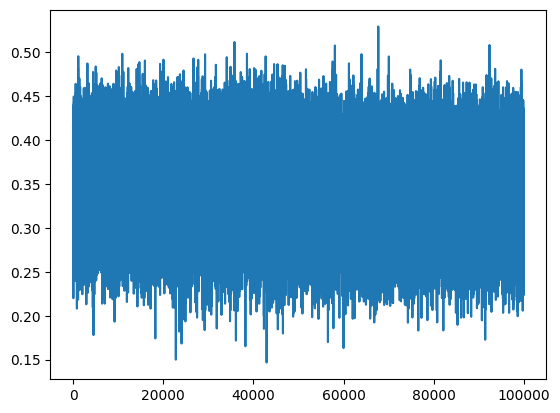

In [71]:
plt.plot(inxs, np.log10(losses))
# plt.xscale("log")

In [74]:
@torch.no_grad() # disable gradient tracking
def get_loss(data_set):
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    emb = C[x]
    h_preact = emb.view(emb.shape[0], block_size*n_embd) @ W1 #+ b1
    h_preact = batch_norm_gain * (h_preact - batch_mean_running) / batch_std_running + batch_norm_bias
    h = torch.tanh(h_preact) # (x, hidden)
    logits = h @ W2 + b2 # (hidden, vocab_size )
    loss = F.cross_entropy(logits, y)
    print(data_set, loss.item())

get_loss('train')
get_loss('dev')

train 2.1651604175567627
dev 2.2001302242279053


In [80]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
	out = '.' * block_size
	while True:
		emb = C[torch.tensor([str_to_inx[x] for x in out[-block_size:]])] # (1,block_size,d)
		h = torch.tanh(emb.view(1, -1) @ W1) 
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		inx = torch.multinomial(probs, num_samples=1, generator=g).item()
		out = out + inx_to_str[inx]
		if inx == 0:
			break
    
	print(out.replace('.', ''))

curlangquvyllvlubinlliglynck
lunsahnenttubefriggangrighliz
ronzertzevigh
lungtyts
lucn
lucqswnnzs
livebenvith
rontri
diarmxlawl
lucinrllerdhodubbygingflyrsidshuwsckingthsykanmexwriggujtobgnrrixsinck
kaisannsimmndissilswazornnd
lunzleyto
lucxmndroubsrbynn
ndil
luxith
brbynz
dabrctic
qwilmnikenzirlnnorkndle
shfr
furzveeffnkxwarwyndourvanjillanmez
